# Input attribution and Variant effect prediction

In this tutorial we illustrate input feature importance attribution and variant effect prediction.

In [1]:
import os

import numpy as np
import h5py
from keras import backend as K
from keras.layers import Conv2D
from keras.layers import GlobalAveragePooling2D
from pkg_resources import resource_filename

from janggu import Janggu
from janggu import Scorer
from janggu import inputlayer
from janggu import outputdense
from janggu.data import Bioseq
from janggu.data import Cover
from janggu.data import GenomicIndexer
from janggu.data import ReduceDim
from janggu.data import plotGenomeTrack
from janggu.data import LineTrack
from janggu.data import SeqTrack
from janggu.layers import DnaConv2D
from janggu import input_attribution

np.random.seed(1234)

/home/wkopp/anaconda3/envs/jdev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First, we need to specify the output directory in which the results are stored and load the datasets. We also specify the number of epochs to train the model and the sequence feature order.

In [2]:
order = 3
epochs = 100

In [3]:
os.environ['JANGGU_OUTPUT'] = '/home/wkopp/janggu_examples'

# load the dataset
# The pseudo genome represents just a concatenation of all sequences
# in sample.fa and sample2.fa. Therefore, the results should be almost
# identically to the models obtained from classify_fasta.py.
REFGENOME = resource_filename('janggu', 'resources/pseudo_genome.fa')
VCFFILE = resource_filename('janggu', 'resources/pseudo_snps.vcf')
# ROI contains regions spanning positive and negative examples
ROI_TRAIN_FILE = resource_filename('janggu', 'resources/roi_train.bed')
ROI_TEST_FILE = resource_filename('janggu', 'resources/roi_test.bed')

# PEAK_FILE only contains positive examples
PEAK_FILE = resource_filename('janggu', 'resources/scores.bed')

In [4]:
# Training input and labels are purely defined genomic coordinates
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   binsize=200,
                                   store_whole_genome=True,
                                   order=order)

LABELS = Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200)


DNA_TEST = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                        roi=ROI_TEST_FILE,
                                        binsize=200,
                                        store_whole_genome=True,
                                        order=order)

LABELS_TEST = Cover.create_from_bed('peaks',
                                    roi=ROI_TEST_FILE,
                                    bedfiles=PEAK_FILE,
                                    binsize=200,
                                    resolution=200)

loading from lazy loader
loading from bed lazy loader
loading from lazy loader
loading from bed lazy loader


Define and fit a new model

In [5]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model_dnaconv(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    A more elegant way of scanning both strands for motif occurrences
    is achieved by the DnaConv2D layer wrapper, which internally
    performs the convolution operation with the normal kernel weights
    and the reverse complemented weights.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        layer = DnaConv2D(Conv2D(params[0], (params[1], 1),
                                 activation=params[2]))(layer)
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output


# create a new model object
model = Janggu.create(template=double_stranded_model_dnaconv,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=ReduceDim(LABELS))

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])

hist = model.fit(DNA, ReduceDim(LABELS), epochs=epochs)

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)

Generated model-id: '6acf30da11d48d4d96ed0669bf3a52f4'
Epoch 1/100
244/244 [==============================] - 3s 14ms/step - loss: 0.6362 - acc: 0.6424
Epoch 2/100
244/244 [==============================] - 2s 9ms/step - loss: 0.5205 - acc: 0.7672
Epoch 3/100
244/244 [==============================] - 2s 9ms/step - loss: 0.4636 - acc: 0.7976
Epoch 4/100
244/244 [==============================] - 2s 9ms/step - loss: 0.4240 - acc: 0.8173
Epoch 5/100
244/244 [==============================] - 2s 9ms/step - loss: 0.3951 - acc: 0.8330
Epoch 6/100
244/244 [==============================] - 2s 9ms/step - loss: 0.3708 - acc: 0.8450
Epoch 7/100
244/244 [==============================] - 2s 9ms/step - loss: 0.3490 - acc: 0.8547
Epoch 8/100
244/244 [==============================] - 2s 10ms/step - loss: 0.3280 - acc: 0.8657
Epoch 9/100
244/244 [==============================] - 2s 9ms/step - loss: 0.3081 - acc: 0.8776
Epoch 10/100
244/244 [==============================] - 2s 9ms/step - loss: 0.2

244/244 [==============================] - 2s 9ms/step - loss: 0.0194 - acc: 0.9982
Epoch 85/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0192 - acc: 0.9980
Epoch 86/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0187 - acc: 0.9980
Epoch 87/100
244/244 [==============================] - 2s 10ms/step - loss: 0.0181 - acc: 0.9987
Epoch 88/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0175 - acc: 0.9983
Epoch 89/100
244/244 [==============================] - 2s 10ms/step - loss: 0.0171 - acc: 0.9983
Epoch 90/100
244/244 [==============================] - 2s 10ms/step - loss: 0.0167 - acc: 0.9991
Epoch 91/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0161 - acc: 0.9988
Epoch 92/100
244/244 [==============================] - 2s 10ms/step - loss: 0.0159 - acc: 0.9986
Epoch 93/100
244/244 [==============================] - 2s 9ms/step - loss: 0.0157 - acc: 0.9988
Epoch 94/100
244/244 [=================

The toy example illustrates a binary classification example composed of Oct4 and Mafk binding sites. 
The true Oct4 binding sites have been labeled with ones while the Mafk binding sites are labeled zeros.

For a sanity check we inspect the predicted values for a few data points.

In [6]:
pred = model.predict(DNA_TEST)
cov_pred = Cover.create_from_array('BindingProba', pred, LABELS_TEST.gindexer)

print('Oct4 predictions scores should be greater than Mafk scores:')
print('Prediction score examples for Oct4')
for i in range(4):
    print('{}.: {}'.format(i, cov_pred[i]))
print('Prediction score examples for Mafk')
for i in range(1, 5):
    print('{}.: {}'.format(i, cov_pred[-i]))

Oct4 predictions scores should be greater than Mafk scores:
Prediction score examples for Oct4
0.: [[[[0.99923718]]]]
1.: [[[[0.92741543]]]]
2.: [[[[0.99872404]]]]
3.: [[[[0.991041]]]]
Prediction score examples for Mafk
1.: [[[[0.72262925]]]]
2.: [[[[0.00450002]]]]
3.: [[[[0.00130975]]]]
4.: [[[[9.16392855e-06]]]]


In order to perform input feature attribution, we utilize the 'input_attribution' method for a genomic region of interest.

Underneath, the result is illustrated visually. It highlights an Oct4 binding sites occuring at the left peak.

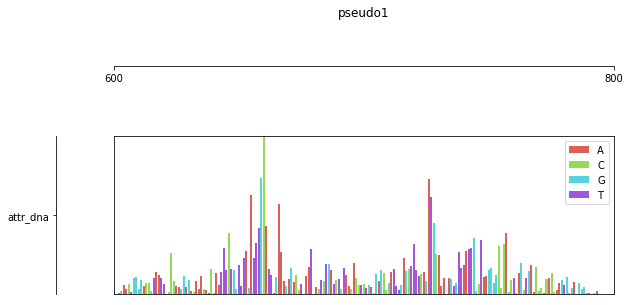

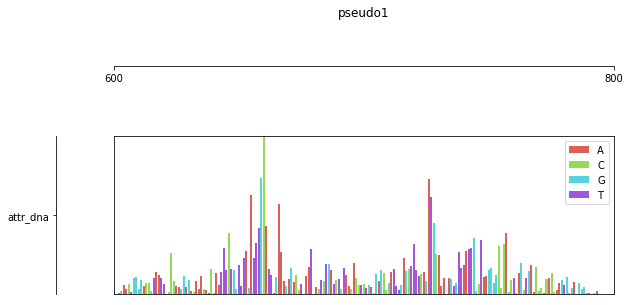

In [7]:
# Extract the 4th interval to perform input feature importance attribution
# which represents an Oct4 bound region
gi = DNA.gindexer[3]
chrom = gi.chrom
start = gi.start
end = gi.end
attr_oct = input_attribution(model, DNA, chrom=chrom, start=start, end=end)

# visualize the important sequence features
plotGenomeTrack(SeqTrack(attr_oct[0]), chrom, start, end)

By comparison, the input attribution for a Mafk binding sites highlights a Mafk motif in the center.

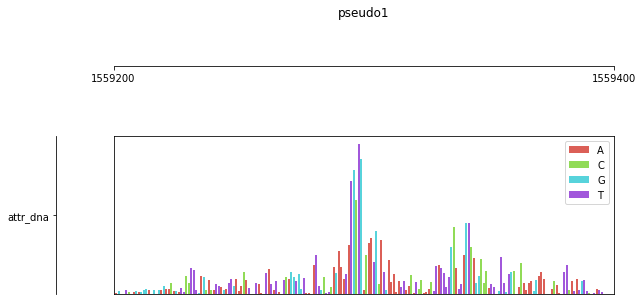

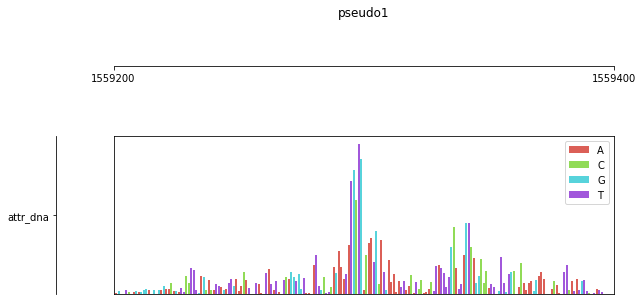

In [8]:
# For the comparison, extract an interval
# representing a Mafk bound region and visualize the
# important features.
gi = DNA.gindexer[7796]
chrom = gi.chrom
start = gi.start
end = gi.end
attr_mafk = input_attribution(model, DNA, chrom=chrom, start=start, end=end)

plotGenomeTrack(SeqTrack(attr_mafk[0]), chrom, start, end)

In order to perform variant effect prediction, we need the DNA sequence loaded for the whole genome into a Bioseq object and a VCF file containing single nucleotide variant.

The result of this analysis is stored in two files: scores.hdf5 and snps.bed.gz.

In [9]:
# output directory for the variant effect prediction
vcfoutput = os.path.join(os.environ['JANGGU_OUTPUT'], 'vcfoutput')
os.makedirs(vcfoutput, exist_ok=True)

# perform variant effect prediction using Bioseq object and
# a VCF file
scoresfile, variantsfile = model.predict_variant_effect(DNA,
                                                        VCFFILE,
                                                        conditions=['feature'],
                                                        output_folder=vcfoutput)

scoresfile = os.path.join(vcfoutput, 'scores.hdf5')
variantsfile = os.path.join(vcfoutput, 'snps.bed.gz')

scores.hdf5 contains a variety of scores for each variant. The most important ones are refscore and altscore which are used to derive the score difference and the logoddsscore.

In [10]:
# parse the variant effect predictions (difference between
# reference and alternative variant) into a Cover object
# for the purpose of visualization
f = h5py.File(scoresfile, 'r')

for name in f:
    print(name)
    

altscore
diffscore
labels
logoddsscore
refscore


Finally, we can convert the variant predictions (the score differences in this case) along with the genomic context with other genomic tracks.

In [11]:
gindexer = GenomicIndexer.create_from_file(variantsfile, None, None)

snpcov = Cover.create_from_array('snps', f['diffscore'],
                                 gindexer,
                                 store_whole_genome=True,
                                 padding_value=np.nan)
snpcov = Cover.create_from_array('snps', f['diffscore'],
                                 gindexer,
                                 store_whole_genome=False,
                                 padding_value=np.nan)

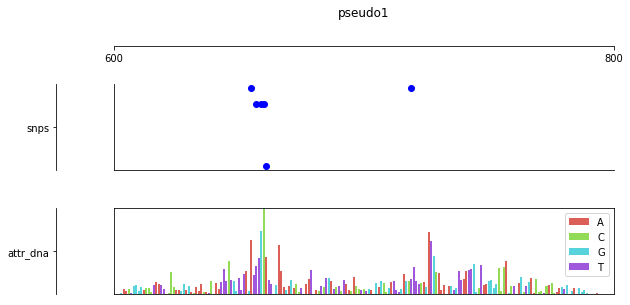

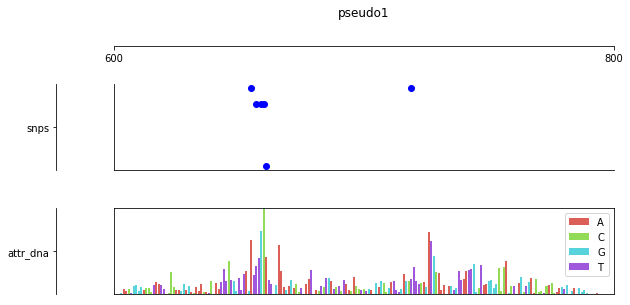

In [12]:
gi = DNA.gindexer[3]
chrom = gi.chrom
start = gi.start
end = gi.end

plotGenomeTrack([LineTrack(snpcov,
                           linestyle="None"), SeqTrack(attr_oct[0])],
                chrom, start, end)

The score difference shows a dip around the site that is indicated as most important from the input attribution as well.